In [16]:
import os
import re

import torch

import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import v2 as T

import utils
from engine import train_one_epoch, evaluate

import matplotlib.pyplot as plt

In [18]:
import zipfile

with zipfile.ZipFile("Dataset_BUSI_with_GT.zip", 'r') as zip_ref:
    zip_ref.extractall("")

In [41]:
class BreastCancerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = []
        self.masks = []
        #subsets = [x for x in os.listdir(root) if re.search(
        #    pattern="\..*", string=x) == None]

        subsets = ["benign", "malignant"]

        for subset in subsets:
            for file in os.listdir(os.path.join(root, subset)):
                if re.search(pattern=".*mask.*", string=file) == None:
                    self.imgs.append(os.path.join(subset, file))
                if re.search(pattern=".*mask\.png", string=file) != None:
                    self.masks.append(os.path.join(subset, file))

        self.imgs = sorted(self.imgs)
        self.masks = sorted(self.masks)

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.imgs[idx])
        mask_path = os.path.join(self.root, self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # label as normal, benign, malignant
        if re.search("^n.*", self.imgs[idx]) != None:
            labels = torch.tensor((0,), dtype=torch.int64)

        if re.search("^b.*", self.imgs[idx]) != None:
            labels = torch.tensor((1,), dtype=torch.int64)

        if re.search("^m.*", self.imgs[idx]) != None:
            labels = torch.tensor((2,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [38]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 2 cancer classes + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [39]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [35]:
def get_transform(train):
    transforms = []
    if train:
        pass
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [43]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3
# use our dataset and defined transformations
dataset = BreastCancerDataset("Dataset_BUSI_with_GT", get_transform(train=True))
dataset_test = BreastCancerDataset("Dataset_BUSI_with_GT", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# set number of training epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/299]  eta: 0:02:44  lr: 0.000022  loss: 3.9330 (3.9330)  loss_classifier: 1.4062 (1.4062)  loss_box_reg: 0.1194 (0.1194)  loss_mask: 2.3618 (2.3618)  loss_objectness: 0.0336 (0.0336)  loss_rpn_box_reg: 0.0119 (0.0119)  time: 0.5508  data: 0.0203  max mem: 7573
Epoch: [0]  [ 10/299]  eta: 0:02:38  lr: 0.000189  loss: 3.0978 (3.0075)  loss_classifier: 1.1387 (1.0367)  loss_box_reg: 0.1192 (0.1142)  loss_mask: 1.8004 (1.8210)  loss_objectness: 0.0218 (0.0295)  loss_rpn_box_reg: 0.0048 (0.0062)  time: 0.5472  data: 0.0258  max mem: 7573
Epoch: [0]  [ 20/299]  eta: 0:02:29  lr: 0.000357  loss: 1.3978 (2.0624)  loss_classifier: 0.2885 (0.6238)  loss_box_reg: 0.1159 (0.1216)  loss_mask: 1.0018 (1.2897)  loss_objectness: 0.0153 (0.0215)  loss_rpn_box_reg: 0.0048 (0.0057)  time: 0.5348  data: 0.0279  max mem: 7573
Epoch: [0]  [ 30/299]  eta: 0:02:26  lr: 0.000525  loss: 0.7714 (1.6298)  loss_classifier: 0.1446 (0.4709)  loss_box_reg: 0.1123 (0.1189)  loss_mask: 0.5104 (1.0112) 

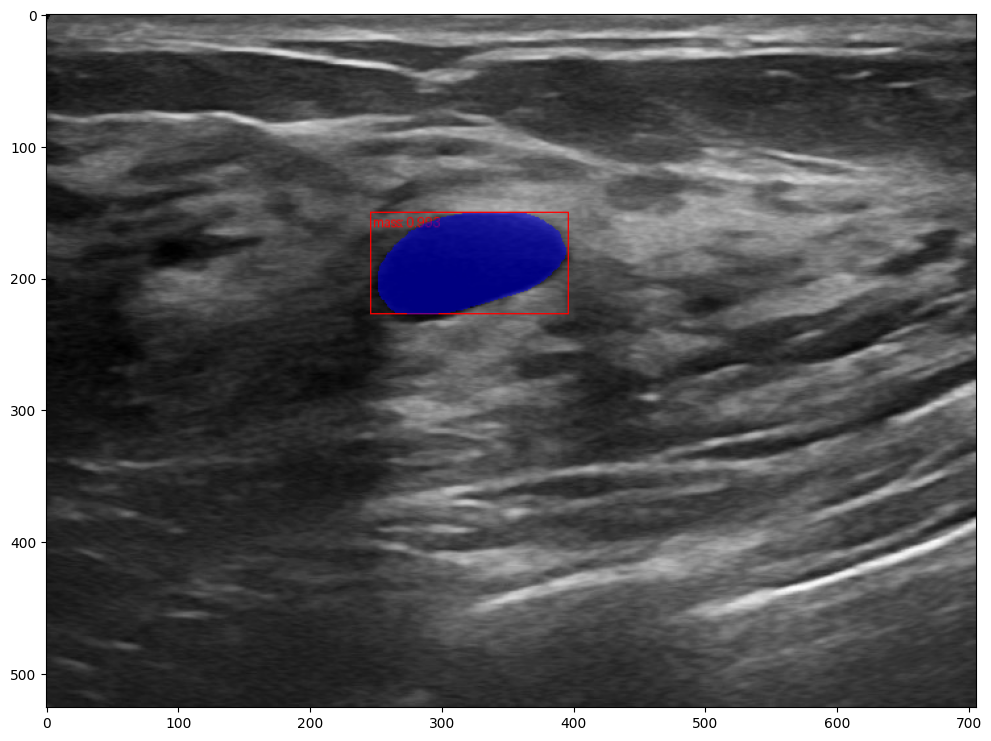

In [46]:
image = read_image("Dataset_BUSI_with_GT/benign/benign (40).png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"mass: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))